In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

In [61]:
# load data
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', 1000)
df = pd.read_excel('wr_data.xlsx')

# split data
labels_all = df.iloc[:, 0:3]
x_all = df.iloc[:, 4:-13] # all features
y_all = df.iloc[:, -2:-1] # all y data
train_x = df.iloc[54:, 4:-13] # features with at least 3 nfl years
train_y = df.iloc[54:, -2:-1] # y data with at least 3 nfl years

# drop samples of players drafted in first 140 picks who played under 10 games
df_tj = train_x.join(train_y).join(df.iloc[45:, -4:-3])
from sklearn.utils import shuffle
df_tj = shuffle(df_tj)

#thresholds
# 1. if played under 10 games but was a top 140 pick -> drop from training set
df_tj = df_tj.drop(df_tj[(df_tj.nfl_g_y1 < 10) & (df_tj.DP < 140)].index)
# 2. if not a top 140 pick, played under 10 games, and scored over 10 ppg, drop data from training set
df_tj = df_tj.drop(df_tj[(df_tj.nfl_g_y1 < 10) & (df_tj.nfl_y1_ffppg > 10) & (df_tj.DP > 140)].index)

train_x, train_y= df_tj.iloc[:,:-2], df_tj.iloc[:,-2:-1]

In [62]:
missing_threshold = .50
cntr = i = 0

while i < len(train_x.columns):
    if((train_x[train_x.columns[i]].isnull().sum()/len(train_x.index)) > missing_threshold):
        print(train_x.columns[i])
        train_x = train_x.drop(train_x.columns[i], axis=1)
        x_all = x_all.drop(x_all.columns[i], axis=1)
    
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

Total Career Targets/GP
Total Career Routes/GP
Total Career YAC/GP
Total Career Contested Target %
Total Career Contested Catch %
Career Best Targets
Career Best Targets/ GP
Career Best Contested Targets
Career Best Contested RECs
Career Best Routes
Career Best Routes/ GP
Career Best YAC
Career Best Drops
Career Best aDOT
Career Best Catch Rate
Career Best Contested Catch %
Career Best YPRR
Career Best Slot Rate
Career Best YAC/REC
Career Best Targeted QB Rating
Career Best Drop %
Career Average Targets/ GP
Career Average Routes/ GP
Career Average aDOT
Career Average Catch Rate
Career Average Contested Catch %
Career Average YPRR
Career Average Slot Rate
Career Average YAC/REC
Career Average Targeted QB Rating
Career Average Drop %
Bench
Shuttle
3 Cone
Pro Day Bench
Pro Day Vertical
Pro Day Broad
Pro Day Shuttle
Pro Day 3 Cone
> 39 features were deleted.
> 105 features remain.


In [63]:
# drop all PPR features
cntr = i = 0

while i < len(x_all.columns):
    if "PPR" in x_all.columns[i]:
        print(x_all.columns[i])
        x_all = x_all.drop(x_all.columns[i], axis=1)
        train_x = train_x.drop(train_x.columns[i], axis=1)
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')

> 0 features were deleted.
> 105 features remain.


In [64]:
# drop all Pro Day features
cntr = i = 0

while i < len(x_all.columns):
    if "Pro Day" in x_all.columns[i]:
        print(x_all.columns[i])
        x_all = x_all.drop(x_all.columns[i], axis=1)
        train_x = train_x.drop(train_x.columns[i], axis=1)
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')

Pro Day 40 time
> 1 features were deleted.
> 104 features remain.


In [65]:
# drop all Kick Return features
cntr = i = 0

while i < len(x_all.columns):
    if "Return" in x_all.columns[i]:
        print(x_all.columns[i])
        x_all = x_all.drop(x_all.columns[i], axis=1)
        train_x = train_x.drop(train_x.columns[i], axis=1)
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')

Career Best Returns
Career Best Return Yards
Career Best Return TDs
> 3 features were deleted.
> 101 features remain.


In [66]:
# drop all Over TM AVG features
cntr = i = 0

while i < len(x_all.columns):
    if "TM AVG" in x_all.columns[i]:
        print(x_all.columns[i])
        x_all = x_all.drop(x_all.columns[i], axis=1)
        train_x = train_x.drop(train_x.columns[i], axis=1)
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')

Career Best YDs/REC Over TM AVG
Career Best SCRIM YDs/Touch Over TM AVG
Career Average YDs/REC Over TM AVG
Career Average SCRIM YDs/Touch Over TM AVG
> 4 features were deleted.
> 97 features remain.


In [67]:
# drop features with low correlation
corr_threshold = .05
cntr = i = 0

while i < len(train_x.columns):
    if(abs(train_x[train_x.columns[i]].corr(train_y[train_y.columns[0]])) < corr_threshold):
        print(train_x.columns[i])
        train_x = train_x.drop(train_x.columns[i], axis=1)
        x_all = x_all.drop(x_all.columns[i], axis=1)
    
        cntr += 1
    else:
        i += 1

print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

Career Best Rush ATTs
Career Best Rush TDs
Career Best RUSH ATT MS
Career Best Yards/ REC
Career Best SCRIM Yards/ Touch
Career Average RUSH ATT MS
RUSH CD
Height
Weight
Hand Size
Arm Length
> 11 features were deleted.
> 86 features remain.


In [68]:
# remove highly collinear features, keeping the feature w/strongest correlation to y-var
corr_thres = .75
drop_cntr = i = j_flag = i_flag = 0

while i < len(train_x.columns):
    j = i+1
    while j < len(train_x.columns):
        if (abs(train_x[train_x.columns[i]].corr(train_x[train_x.columns[j]])) > corr_thres):
            if abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))) <= abs(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))):
                print("deleted:", train_x.columns[i], " ", train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),
                      "\nkept:\t", train_x.columns[j], " ", train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),"\n");
                train_x = train_x.drop(train_x.columns[i], axis=1)
                x_all = x_all.drop(x_all.columns[i], axis=1)
                drop_cntr += 1
                i_flag = 1
                break
            else:
                print("deleted:", train_x.columns[j], " ", train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),
                      "\nkept:\t", train_x.columns[i], " ", train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')),"\n");
                train_x = train_x.drop(train_x.columns[j], axis=1)
                x_all = x_all.drop(x_all.columns[j], axis=1)
                drop_cntr += 1
                j_flag = 1
        if j_flag == 0:
            j += 1
        j_flag = 0
    if i_flag == 0:
        i += 1
    i_flag = 0
                                                                                            
print('\033[1m' + '> ' + str(drop_cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

deleted: Total Career REC/GP   0.25910733386692925 
kept:	 Total Career REC Yards/GP   0.2959244487442361 

deleted: Total Career REC Yards/GP   0.2959244487442361 
kept:	 Total Career REC TDs/GP   0.30522584631403327 

deleted: Total Career REC TDs/GP   0.30522584631403327 
kept:	 Total Career SCRIM Yards/GP   0.31382673177971204 

deleted: Total Career SCRIM Yards/ Touch   0.12437057575338151 
kept:	 Total Career REC Yards/REC   0.13276172121260746 

deleted: Career Average Yards/ REC   0.10703354763978826 
kept:	 Total Career REC Yards/REC   0.13276172121260746 

deleted: Career Average SCRIM Yards/Touch   0.1058757182024736 
kept:	 Total Career REC Yards/REC   0.13276172121260746 

deleted: Total Career Touches/GP   0.22498602739158308 
kept:	 Total Career SCRIM Yards/GP   0.31382673177971204 

deleted: Total Career SCRIM Yards/GP   0.31382673177971204 
kept:	 Total Career SCRIM TDs/GP   0.3158480274968239 

deleted: Total Career SCRIM TDs/GP   0.3158480274968239 
kept:	 Total Care

In [69]:
# manual drops
# Agility Score: the sum of a player’s 20-Yard Short Shuttle time and 3-Cone Drill times
# Freak Score: combines height, weight, 40-time

#[]

list_to_drop = ['BMI','Career Best Rush Yards','Freak Score']
cntr = 0

for i in list_to_drop:
    x_all = x_all.drop(i, axis=1)
    train_x = train_x.drop(i, axis=1)
    cntr += 1


print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')

> 3 features were deleted.
> 14 features remain.


In [70]:
print(train_x.isna().sum())

DP                                   0
Draft Age                            0
Total Career REC Yards/REC           0
Career Average REC Yards/ TM PA      0
Career Average Touch/ Play           0
Career Average Total Yards/GP        0
Career Average Total TDs/GP          0
SCRIM CD                             0
WR BOA (30%)                       333
Adjusted 40 time                   107
Vertical                           325
Broad                              342
RAS                                115
Agility Score                      179
dtype: int64


In [71]:
# fill missing values
train_x['WR BOA (30%)'].fillna(value=24, inplace=True)
x_all['WR BOA (30%)'].fillna(value=24, inplace=True)
train_x['Adjusted 40 time'].fillna(value=train_x['Adjusted 40 time'].mean(), inplace=True)
x_all['Adjusted 40 time'].fillna(value=x_all['Adjusted 40 time'].mean(), inplace=True)
train_x['Vertical'].fillna(value=train_x['Vertical'].mean(), inplace=True)
x_all['Vertical'].fillna(value=x_all['Vertical'].mean(), inplace=True)
train_x['Broad'].fillna(value=train_x['Broad'].mean(), inplace=True)
x_all['Broad'].fillna(value=x_all['Broad'].mean(), inplace=True)
train_x['RAS'].fillna(value=train_x['RAS'].mean(), inplace=True)
x_all['RAS'].fillna(value=x_all['RAS'].mean(), inplace=True)
train_x['Agility Score'].fillna(value=train_x['Agility Score'].mean(), inplace=True)
x_all['Agility Score'].fillna(value=x_all['Agility Score'].mean(), inplace=True)

<AxesSubplot:>

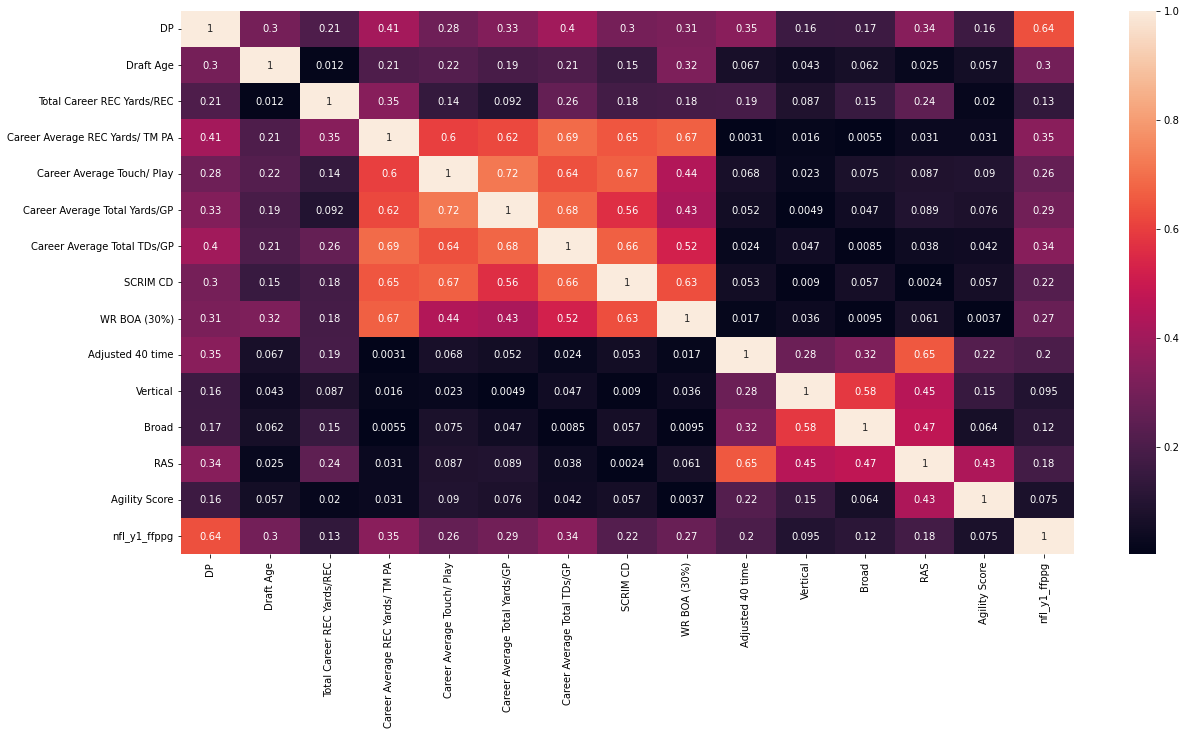

In [72]:
# Correlation Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(abs(train_x.join(train_y).astype('float64').corr()), annot=True)

In [73]:
#todo:
   #set up param_grid
   #figure out best scoring function for scorers
   #note that it is fitting to train_x and train_y, maybe do it with the stratified split instead?
   #make table pretty and post
   #get scoring metrics for resume
    
param_grid = dict(
    learning_rate=[0.01,0.05,0.1],
    n_estimators=[50,100,150,200,250],
    subsample=[.8],
    max_features=[5,7,10,15],
    max_depth=[2,3,4,5],
    min_samples_leaf=[3,5,7,10,15],
    min_samples_split=[5,10,20,30],
)
scorer_05p = make_scorer(
    mean_pinball_loss,
    alpha=.05,
    greater_is_better=False,  # maximize the negative loss
)
scorer_95p = make_scorer(
    mean_pinball_loss,
    alpha=.95,
    greater_is_better=False,  # maximize the negative loss
)

In [22]:
# gridsearch for 0.05 quantile
gsearch_low = GridSearchCV(
    estimator=GradientBoostingRegressor(alpha=0.05,loss='quantile'),
    param_grid=param_grid,
    scoring=scorer_05p,
    n_jobs=-1,
    cv=5)
gsearch_low.fit(train_x, np.ravel(train_y))
gsearch_low.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'max_features': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 20,
 'n_estimators': 250,
 'subsample': 0.8}

In [23]:
# gridsearch for 0.50 quantile, which minimizes the mean absolute error (MAE)
gsearch_median = GridSearchCV(
    estimator=GradientBoostingRegressor(alpha=0.50,loss='quantile'),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5)
gsearch_median.fit(train_x, np.ravel(train_y))
gsearch_median.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'max_features': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100,
 'subsample': 0.8}

In [24]:
# gridsearch for 0.95 quantile
gsearch_high = GridSearchCV(
    estimator=GradientBoostingRegressor(alpha=0.95,loss='quantile'),
    param_grid=param_grid,
    scoring=scorer_95p,
    n_jobs=-1,
    cv=5)
gsearch_high.fit(train_x, np.ravel(train_y))
gsearch_high.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'max_features': 15,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 50,
 'subsample': 0.8}

In [25]:
low_preds = np.zeros(len(x_all))
median_preds = np.zeros(len(x_all))
high_preds = np.zeros(len(x_all))
# average predictions over a range of seeds [0,99]
for x in range(100):
    low_preds = (low_preds + gsearch_low.predict(x_all))/2
    median_preds = (median_preds + gsearch_median.predict(x_all))/2
    high_preds = (high_preds + gsearch_high.predict(x_all))/2
    
output = pd.DataFrame({'5%':low_preds,'50%':median_preds,'95%':high_preds}).astype('float')
print("done")

done


In [74]:
# printing results prints dataframe but takes too long to render on github
# def red_background_2022(cell_value):
#     highlight = 'background-color: tomato;'
#     default = ''
#     if cell_value == 2022:
#         return highlight
#     else:
#         return default 
    
# results = labels_all.join(y_all).join(output)
# #results = labels_all.join(output)
# #results = results.sort_values(by=['0.50'], ascending=False).reset_index(drop=True)
# results = results.sort_values(by=['Draft Year','50%'], ascending=False).reset_index(drop=True)
# #results = results.drop('Draft Year', axis=1)
# results.loc[:, "nfl_y1_ffppg"] = results["nfl_y1_ffppg"].map('{:.2f}'.format)
# results["5%"] = results["5%"].map('{:.2f}'.format)
# results["50%"] = results["50%"].map('{:.2f}'.format)
# results["95%"] = results["95%"].map('{:.2f}'.format)
# cm = sns.color_palette("inferno", as_cmap=True)
# results1 = results.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).background_gradient(cmap=cm, subset=['5%','50%','95%'],vmin=-0.99, vmax=17.07)
# results1.set_properties(**{'text-align': 'center'},subset=['5%','50%','95%','Player','School'])
# #results.style.background_gradient(cmap=cm, subset=['0.05','0.50','0.95']).applymap(red_background_2022)

In [27]:
# check the 90% interval coverage accuracy
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


In [28]:
coverage_fraction(train_y.values.ravel(), gsearch_low.predict(train_x), gsearch_high.predict(train_x))


0.9146853146853147